In [ ]:
import pandas as pd

## Exploratory Data Analysis

In [ ]:
# load in df
df = pd.read_csv('stats.csv')
df.head()

,"last_name, first_name",player_id,year,ab,pa,home_run,strikeout,walk,k_percent,bb_percent,...,b_swinging_strike,woba,xwoba,sweet_spot_percent,barrel_batted_rate,hard_hit_percent,avg_best_speed,avg_hyper_speed,whiff_percent,swing_percent
0,"Beltré, Adrian",134181,2017,340,389,17,52,39,13.4,10.0,...,122,0.384,0.358,36.1,5.8,32.5,97.066970,92.551073,18.7,46.8
1,"Beltrán, Carlos",136860,2017,467,509,14,102,33,20.0,6.5,...,146,0.283,0.284,29.4,4.6,31.0,97.251447,92.653848,19.8,47.9
2,"Werth, Jayson",150029,2017,252,289,10,69,35,23.9,12.1,...,92,0.311,0.329,33.2,8.2,40.7,99.992580,94.104058,21.9,38.6
3,"Arroyo, Bronson",276520,2017,26,29,0,10,0,34.5,0.0,...,10,0.135,0.210,36.8,0.0,0.0,89.654834,89.315833,26.2,50.0
4,"Dickey, R.A.",285079,2017,61,68,0,12,0,17.6,0.0,...,17,0.129,0.139,19.6,0.0,0.0,83.338039,88.117691,14.8,74.3


In [ ]:
# shape of dataset
rows, cols = df.shape[0], df.shape[0]

print(f'Number of Rows: {rows}')
print(f'Number of Columns: {cols}')

Number of Rows: 5419
Number of Columns: 5419


In [ ]:
# all columns
print(df.columns)

Index(['last_name, first_name', 'player_id', 'year', 'ab', 'pa', 'home_run',
       'strikeout', 'walk', 'k_percent', 'bb_percent', 'batting_avg',
       'slg_percent', 'on_base_percent', 'on_base_plus_slg', 'b_rbi',
       'b_swinging_strike', 'woba', 'xwoba', 'sweet_spot_percent',
       'barrel_batted_rate', 'hard_hit_percent', 'avg_best_speed',
       'avg_hyper_speed', 'whiff_percent', 'swing_percent'],
      dtype='object')


## Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# remove non-numeric columns
id_cols = [col for col in df.columns if 'name' in col.lower() or 'id' in col.lower()]
df = df.drop(columns=id_cols, errors='ignore')

y = df['home_run']
X = df.drop(columns=['home_run'])

# split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (4335, 22)
Test shape: (1084, 22)


## Random Forest

Model Variant 1: Only use the top 10 correlated features with `home_run`

In [ ]:
correlations = df.corr()['home_run'].abs().sort_values(ascending=False)
top10 = correlations.index[1:11]

X_train_top10 = X_train[top10]
X_test_top10 = X_test[top10]

print("Top 10 correlated features:", list(top10))

Top 10 correlated features: ['b_rbi', 'b_swinging_strike', 'strikeout', 'pa', 'ab', 'walk', 'slg_percent', 'on_base_plus_slg', 'xwoba', 'woba']


In [ ]:
# Fit Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor

dt_top10 = DecisionTreeRegressor(
    max_depth=5,
    min_samples_leaf=10,
    random_state=42
)

dt_top10.fit(X_train_top10, y_train)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, random_state=42)

In [ ]:
# Evaluate model performance
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

y_train_pred = dt_top10.predict(X_train_top10)
y_test_pred = dt_top10.predict(X_test_top10)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse  = np.sqrt(mean_squared_error(y_test,  y_test_pred))

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# merge all metrics into a single df
metrics_table = pd.DataFrame({
    "Train": [train_r2, train_rmse, train_mae],
    "Test": [test_r2, test_rmse, test_mae]
}, index=["R²", "RMSE", "MAE"])

metrics_table

,Train,Test
R²,0.916609,0.897509
RMSE,2.786719,3.150940
MAE,1.918584,2.133808


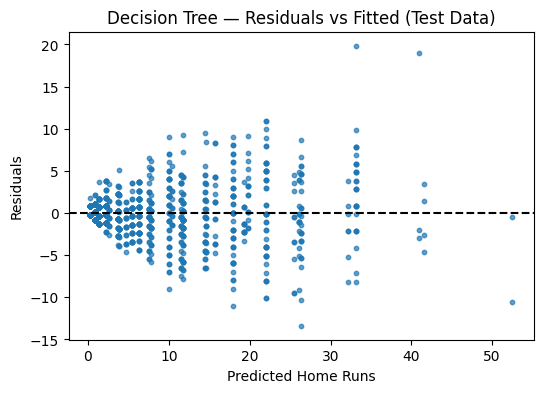

In [ ]:
# Plot residual plot
import matplotlib.pyplot as plt

residuals = y_test - y_test_pred

plt.figure(figsize=(6,4))
plt.scatter(y_test_pred, residuals, s=10, alpha=0.7)
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Predicted Home Runs")
plt.ylabel("Residuals")
plt.title("Decision Tree — Residuals vs Fitted (Test Data)")
plt.show()

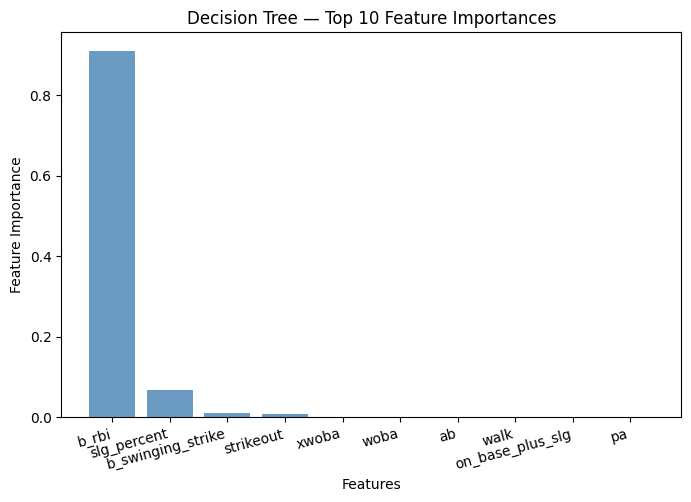

In [ ]:
# Plot model feature importances
feature_importances = dt_top10.feature_importances_
orders_ft = np.argsort(feature_importances)[::-1]
features_sorted = [X_train_top10.columns[i] for i in orders_ft]
importances_sorted = feature_importances[orders_ft]

plt.figure(figsize=(8,5))
bars = plt.bar(features_sorted, importances_sorted, color='steelblue', alpha=0.8)
plt.xlabel("Features")
plt.ylabel("Feature Importance")
plt.title("Decision Tree — Top 10 Feature Importances")
plt.xticks(rotation=15, ha="right")
plt.show()